1. Write a query to find the average salary both yearly (salary_year_avg) and hourly (salary_hour_avg) for job postings that were posted after June 1, 2023. Group the results by job schedule type.

In [ ]:
SELECT
    AVG(salary_year_avg) AS salary_year_avg,
    AVG(salary_hour_avg) AS salary_hour_avg,
    job_schedule_type
FROM job_postings_fact
WHERE job_posted_date > '2023-06-01'
    AND (salary_year_avg IS NOT NULL
    OR salary_hour_avg IS NOT NULL)
GROUP BY job_schedule_type
;

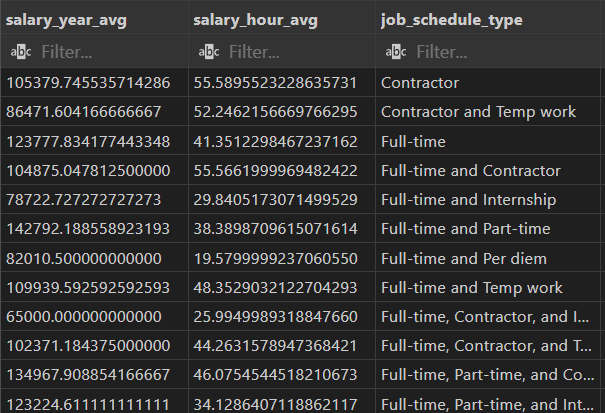

2. Write a query to count the number of job postings for each month in 2023, adjusting (hint) the month. Group by and order by the month.

In [ ]:
SELECT
    COUNT(job_id) AS job_posted_count,
    EXTRACT(MONTH FROM job_posted_date) AS month
FROM
    job_postings_fact
WHERE job_posted_date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY month
ORDER BY month;

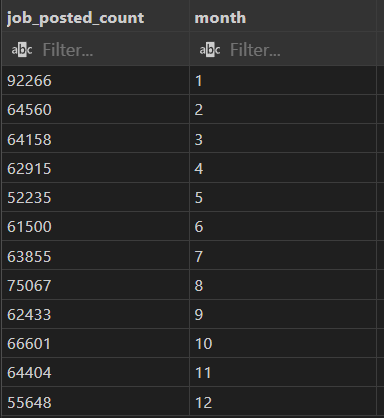

3. Write a query to find companies (include company name) that have posted jobs offering health insurance, where these postings were made in the second quarter of 2023. Use date extraction to filter by quarter.

In [ ]:
SELECT
    cd.name AS company_name,
    EXTRACT(YEAR FROM job_posted_date) AS year,
    EXTRACT(QUARTER FROM job_posted_date) AS quarter,
    jpf.job_health_insurance
FROM
    job_postings_fact jpf
INNER JOIN company_dim cd
    ON jpf.company_id = cd.company_id
WHERE job_health_insurance IS TRUE
GROUP BY 1,2,3,4
HAVING EXTRACT(YEAR FROM job_posted_date) = 2023
    AND EXTRACT(QUARTER FROM job_posted_date) = 2
ORDER BY 1
;

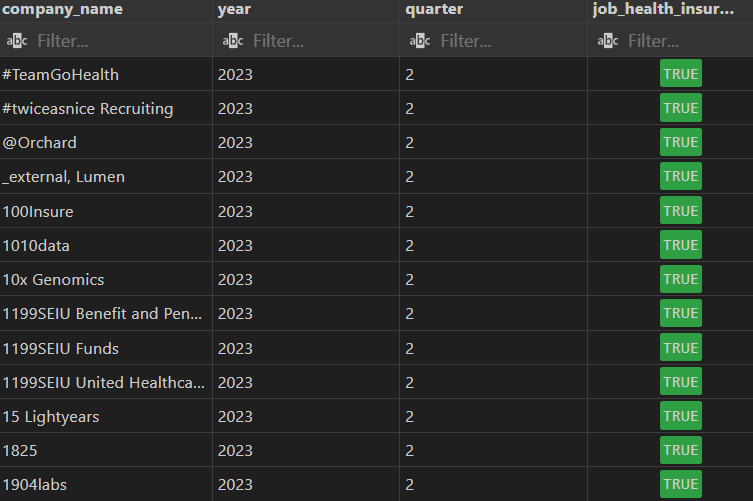

4.

In [ ]:
SELECT
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_location = 'Anywhere' THEN 'Remote'
        WHEN job_location = 'New York, NY' THEN 'Local'
        ELSE 'Onsite'
    END AS location_category
FROM job_postings_fact
WHERE job_title_short = 'Data Analyst'
GROUP BY location_category;

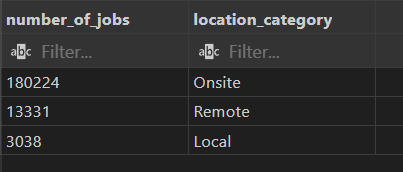

5. To categorize the salaries from each job posting. To see if it fits in desired salary range.
- Put salary into different buckets
- Define what's a high, standard, or low salary with our own conditions
- Why? It is easy to determine which job postings are worth looking at based on salary.
- Bucketing is a common practice in data analysis when viewing categories.
- I only want to look at data analyst roles
- Order from highest to lowest

In [ ]:
SELECT
    job_title_short,
    CASE
        WHEN salary_year_avg < 50000 THEN 'low salary'
        WHEN salary_year_avg BETWEEN 50000 AND 100000 THEN 'standard'
        ELSE 'high'
    END AS salary_category,
    count(job_id) as number_of_jobs
FROM job_postings_fact
WHERE job_title_short = 'Data Analyst'
    AND salary_year_avg IS NOT NULL
GROUP BY 1,2
ORDER BY 2 DESC
;

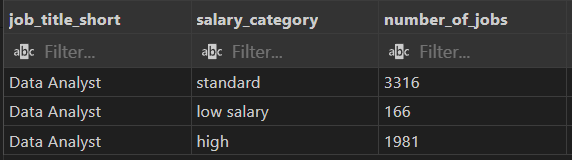

In [ ]:
SELECT
    job_title_short,
    CASE
        WHEN salary_year_avg < 50000 THEN 'low salary'
        WHEN salary_year_avg BETWEEN 50000 AND 100000 THEN 'standard'
        ELSE 'high'
    END AS salary_category,
    salary_year_avg
FROM job_postings_fact
WHERE job_title_short = 'Data Analyst'
    AND salary_year_avg IS NOT NULL
GROUP BY 1,2,3
ORDER BY 3 DESC
;

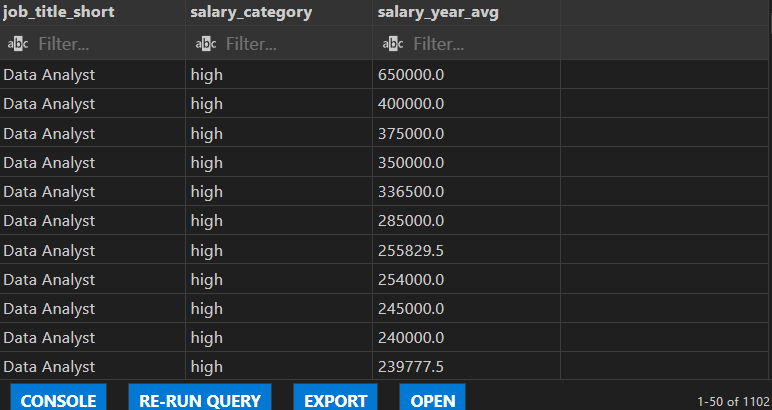

6. Companies that offer jobs without any degree requirements

In [ ]:
SELECT
    company_id,
    name as company_name
FROM company_dim
WHERE company_id in (
    SELECT
        company_id
    FROM job_postings_fact
    WHERE job_no_degree_mention = true
    ORDER BY company_id
);

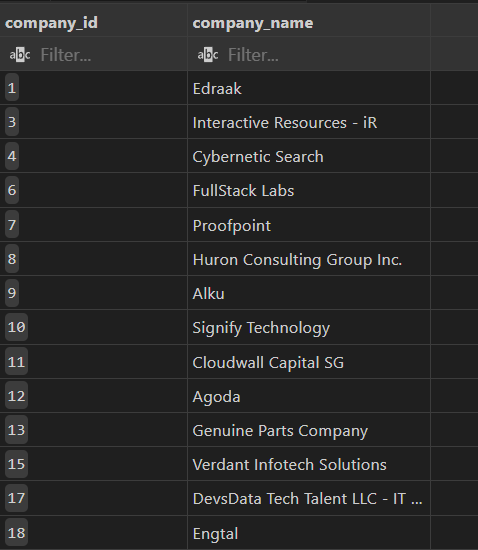

7. Find the companies that have the most job openings.
- Get the total number of job postings per company id.
- Return the total number of jobs with the company name.

In [ ]:
WITH company_job_count AS (
    SELECT
        company_id,
        COUNT(*) AS total_jobs
    FROM job_postings_fact
    GROUP BY company_id
)
SELECT
    company_dim.name AS company_name,
    company_job_count.total_jobs
FROM company_dim
LEFT JOIN company_job_count
    ON company_job_count.company_id = company_dim.company_id
ORDER BY total_jobs DESC
;

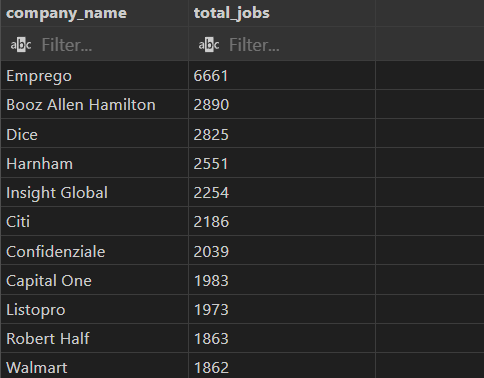

8. Identify the top 5 skills that are most frequently in job postings. Use a subquery to find the skill IDs with the highest counts in the skills_job_dim table and then join this result with the skills_dim table to get the skill names.

In [ ]:
WITH skills_job_count AS (
    SELECT
        skill_id,
        COUNT(*) as count_skill
    FROM skills_job_dim
    GROUP BY 1
)
SELECT
    sd.skills AS name_skill,
    sjc.count_skill
FROM skills_job_count sjc
LEFT JOIN skills_dim sd ON sjc.skill_id = sd.skill_id
ORDER BY 2 DESC
LIMIT 5
;

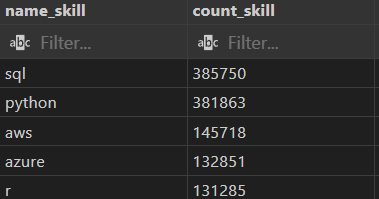

9. Determine the size category ('Small', 'Medium' or 'Large') for each company by first identifying the number of job postings they have. Use a subquery to calculate the total job postings per company. A company is considered 'Small' if it has less than 10 job postings, 'Medium' if the number of job postings is between 10 and 50, and 'Large' if it has more than 50 job postings. Implement a subquery to aggregate job per company before classifying them based on size.

In [ ]:
WITH jobcount as (
    SELECT
        company_id,
        count(*) as job_count
    FROM job_postings_fact
    GROUP BY 1
)
SELECT
    cd.name as company_name,
    j.job_count,
    case
        when job_count < 10 then 'Small'
        when job_count between 10 and 50 then 'Medium'
        else 'Large'
    end as company_category
FROM jobcount j
LEFT JOIN company_dim cd
    ON j.company_id = cd.company_id
--ORDER BY 2 DESC
;

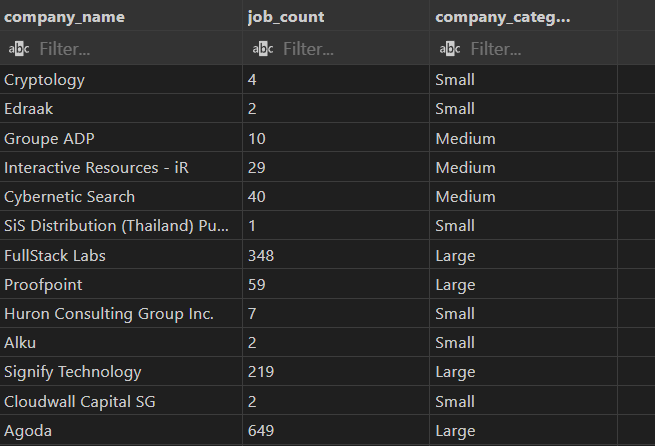